# Imports

In [ ]:
from PIL import Image
from google.colab import drive
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
import math
import os
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
drive.mount("/gdrive")

Mounted at /gdrive


# Pretrained Faster RCNN

We load a Pretrained Faster RCNN model with an Inception ResNet V2 as backbone (https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1). We use the `tensorflow_hub` python package to load the model passing its URL

In [ ]:
detector = hub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1').signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Detector usage example

Load the image to analyze

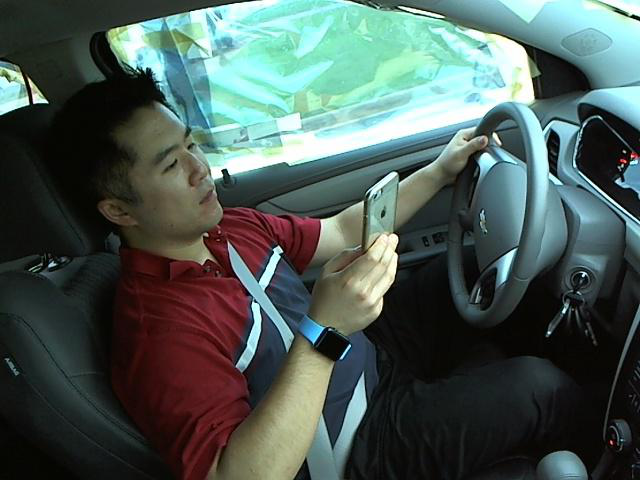

In [ ]:
filename = '/gdrive/MyDrive/Progetto Computational Intelligence/test/c1/img_100230.jpg'
image_pil = Image.open(filename)
image_pil

We run the detector on our image and inspect the output. Looking at the [model documentation](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1), the input must be a `tf.Tensor` of type `float32` with shape `[1, height, width, 3]` with values in `[0.0, 1.0]`.

In [ ]:
image_np = np.array(image_pil)               # convert PIL image to numpy
image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
image_np = image_np.astype(np.float32)       # convert from uint8 to float32
image_np = image_np / 255.                   # scale from [0, 255] -> [0, 1]
image_tf = tf.convert_to_tensor(image_np)    # from numpy to tf.Tensor

The detector outputs are:

 - `detection_boxes`: a `tf.float32` tensor of shape `[N, 4]` containing bounding box coordinates in the following order: `[ymin, xmin, ymax, xmax]`.
 - `detection_class_entities`: a `tf.string` tensor of shape `[N]` containing detection class names as Freebase MIDs.
 - `detection_class_names`: a `tf.string` tensor of shape `[N]` containing human-readable detection class names.

  - `detection_class_labels`: a `tf.int64` tensor of shape `[N]` with class indices.
  - `detection_scores`: a `tf.float32` tensor of shape `[N]` containing detection scores.

In [ ]:
detector_output = detector(image_tf)
detector_output

{'detection_boxes': <tf.Tensor: shape=(100, 4), dtype=float32, numpy=
 array([[0.        , 0.12645377, 0.946864  , 0.96696776],
        [0.20839125, 0.18382286, 0.4861668 , 0.35136977],
        [0.0090714 , 0.5520042 , 0.7904033 , 0.9944191 ],
        [0.41636014, 0.14102487, 0.9976134 , 0.5438288 ],
        [0.1351599 , 0.12341152, 0.9873746 , 0.6955786 ],
        [0.1680901 , 0.69081396, 0.6849531 , 0.87205374],
        [0.13525915, 0.08558485, 1.        , 0.67421323],
        [0.18273613, 0.49702102, 0.98973656, 0.9517636 ],
        [0.        , 0.        , 0.99472576, 0.98464936],
        [0.1500437 , 0.6629457 , 0.6651524 , 0.9026994 ],
        [0.1775554 , 0.32674804, 1.        , 1.        ],
        [0.20345606, 0.88535774, 0.45529297, 0.9945646 ],
        [0.47151494, 0.47975108, 0.703453  , 0.634632  ],
        [0.13447282, 0.22605698, 0.991659  , 0.8841742 ],
        [0.15963537, 0.08504716, 0.51003605, 0.3477808 ],
        [0.15026806, 0.08207512, 0.4587615 , 0.3030949 ],
  

We select the labels and the bounding boxes of the "wheel" and "human hand" regions.

In [ ]:
labels = []

# Get the wheel bounding box with the highest score
wheel_scores = [score for l,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel")]
max_wheel_score = max(wheel_scores)
best_wheel_box = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel" and score == max_wheel_score)]

labels.append("Wheel")
boxes = best_wheel_box

# Get the "best" (with a minimum score) hands bounding boxes
min_hand_score = 0.01
best_hand_boxes = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Human hand" and score >= min_hand_score)]
for i in range(len(best_hand_boxes)):
  labels.append("Human hand")

boxes = np.concatenate((boxes,best_hand_boxes))

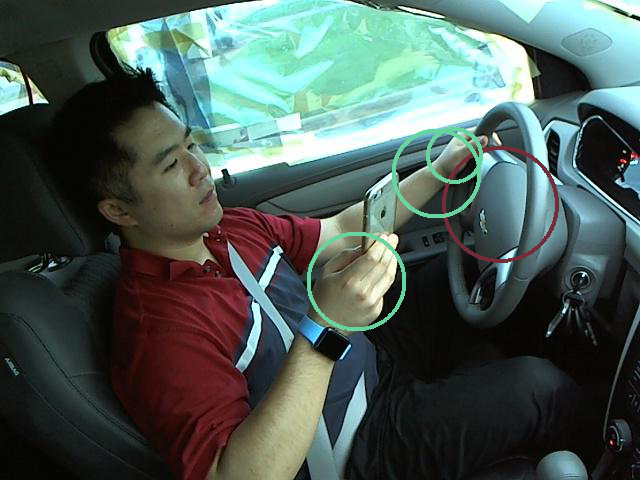

In [ ]:
draw_boxes(filename, boxes, labels)

# Utility functions

Function to obtain the center and radius of the circle **circumscribed** to the given rectangle

In [ ]:
def get_circle(y0, x0, y1, x1):
  #compute radius
  r = math.sqrt(pow((y1-y0)/2,2) + pow((x1-x0)/2,2)) 
  #compute center
  xc = (x0 + x1)/2
  yc = (y0 + y1)/2 

  return r,xc,yc

Function to obtain the center and radius of the circle **inscribed** to the given rectangle

In [ ]:
def get_inscribed_circle(y0, x0, y1, x1):
  #compute radius
  r = min(abs(x1-x0),abs(y1-y0))/2
  #compute center
  xc = (x0 + x1)/2
  yc = (y0 + y1)/2 

  return r,xc,yc

Function to draw circles around the detected areas of interest

In [ ]:
# defaultdict runs the 'pick_random_color' function when we ask for a non-existent key, generating a new color
pick_random_color = lambda: tuple(np.random.randint(0, 256, 3).tolist())
colors = defaultdict(pick_random_color)

def draw_boxes(image_path, boxes, labels):
  """ Load an image and draws bounding boxes on it.
  Args:
    - image_path (str): path to the image to load.
    - boxes (ndarray): a (N,4)-shaped array of normalized [y0, x0, y1, x1] boxes.
    - labels (list): a list of N labels of each box.
  Returns:
    - image (PIL.Image): the image with drawn boxes.
  """
  image = Image.open(image_path).convert('RGB')
  draw = ImageDraw.Draw(image)

  hwhw = np.tile((image.height, image.width), 2)
  boxes = boxes * hwhw  # de-normalize box (scale to image size)

  font = ImageFont.truetype('LiberationSans-Regular.ttf', size=20)
  for (y0, x0, y1, x1), label in zip(boxes, labels):
    color = colors[label]
    tw, th = font.getsize(label)
    
    #compute radius and center of the circle circumscribed to the bounding box
    # r,xc,yc = get_circle(y0, x0, y1, x1) # CIRCUMSCRIBED CIRCLES
    r,xc,yc = get_inscribed_circle(y0, x0, y1, x1) # INSCRIBED CIRCLES
    draw.ellipse((xc-r,yc-r,xc+r,yc+r),outline=color, width=4)

  return image

Function that evaluate different metrics (accuracy,precision,recall,f1-score) of the binary classifier on the **c0**,**c1** and **c6** folders of the **test set**, given a certain **threshold**.

In [ ]:
def evaluate_classifier(function_name,threshold):

  '''
  function_name - name of the function to use in order to classify an image
  threshold - parameter that we use to consider different configurations of the classifier
  '''

  correct_classifications = 0
  true_labels = []
  predicted_labels = []

  # focused drivers, both the hands on the wheel (class 0)
  image_paths = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/c0")
  #image_paths = image_paths[:100] # consider a subset
  true_labels = np.full(len(image_paths),0)
  for image_path in tqdm(image_paths):
    label = function_name("/gdrive/MyDrive/Progetto Computational Intelligence/test/c0/"+image_path,threshold)
    if label == -1: # wheel not detected
      true_labels = np.delete(true_labels,-1)
      continue
    predicted_labels.append(label)
    if label == 0:
      correct_classifications = correct_classifications + 1

  # phone and drinking drivers (class 1)
  image_paths = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/c1")
  #image_paths = image_paths[:100] # consider a subset
  true_labels = np.concatenate((true_labels,np.full(len(image_paths),1)))
  for image_path in tqdm(image_paths):
    label = function_name("/gdrive/MyDrive/Progetto Computational Intelligence/test/c1/"+image_path,threshold)
    if label == -1:
      true_labels = np.delete(true_labels,-1)
      continue
    predicted_labels.append(label)
    if label == 1:
      correct_classifications = correct_classifications + 1

  image_paths = os.listdir("/gdrive/MyDrive/Progetto Computational Intelligence/test/c6")
  #image_paths = image_paths[:100] # consider a subset
  true_labels = np.concatenate((true_labels,np.full(len(image_paths),1)))
  for image_path in tqdm(image_paths):
    label = function_name("/gdrive/MyDrive/Progetto Computational Intelligence/test/c6/"+image_path,threshold)
    if label == -1:
      true_labels = np.delete(true_labels,-1)
      continue
    predicted_labels.append(label)
    if label == 1:
      correct_classifications = correct_classifications + 1

  # convert list to np array
  predicted_labels = np.array(predicted_labels)

  print("------------------------ Threshold = " + str(threshold) + " ------------------------")
  print("Accuracy: " + str(correct_classifications/len(true_labels)))
  print("Precision: " + str(precision_score(true_labels, predicted_labels , average="macro")))
  print("Recall: " + str(recall_score(true_labels, predicted_labels , average="macro")))
  f1_measure = f1_score(true_labels, predicted_labels , average="macro")
  print("F1-Score: " + str(f1_measure))

  # plot the confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax)

  return f1_measure

# Circumscribed circles

Function to classify wheter the driver is keeping boths his hands on the wheel or not. The classification is performed on the overall test set exploiting circles circumscribed to the bounding boxes

In [ ]:
def classify_image(filename,threshold):

  """ Consider a test image and classify it.
  Args:
    - filename (str): path to the image to load
    - threshold (float): distance threshold to use for the classification 
  Returns:
    - class (int): the test image class
  """

  image_pil = Image.open(filename)
  image_np = np.array(image_pil)               # convert PIL image to numpy
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_np = image_np.astype(np.float32)       # convert from uint8 to float32
  image_np = image_np / 255.                   # scale from [0, 255] -> [0, 1]
  image_tf = tf.convert_to_tensor(image_np)    # from numpy to tf.Tensor

  detector_output = detector(image_tf)

  labels = []

  # Get the wheel bounding box with the highest score
  wheel_scores = [score for l,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel")]
  # If the wheel is not detected, the image can be discarded
  if len(wheel_scores) == 0:
    return -1
  max_wheel_score = max(wheel_scores)
  best_wheel_box = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel" and score == max_wheel_score)]

  labels.append("Wheel")
  boxes = best_wheel_box

  # Get the "best" (with a minimum score) hands bounding boxes
  min_hand_score = 0.01
  best_hand_boxes = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Human hand" and score >= min_hand_score)]
  for i in range(len(best_hand_boxes)):
    labels.append("Human hand")

  # If the detector is not able to find human hands it is likely that the hands of the driver are not well-visible on the wheel, threfore we label the driver
  # as not focused (class 1)
  if len(best_hand_boxes) == 0:
    return 1

  boxes = np.concatenate((boxes,best_hand_boxes))

  # boxes[0] -> wheel box
  # boxes[1:] -> hand boxes

  # Get the center and the radius of the wheel circle (without rescaling)
  wheel_radius, wheel_center_x, wheel_center_y = get_circle(boxes[0][0],boxes[0][2],boxes[0][2],boxes[0][3])

  for i,(y0, x0, y1, x1) in zip(range(len(boxes[1:])),boxes[1:]):
    r,xc,yc = get_circle(y0, x0, y1, x1)
    distance = math.sqrt( pow(xc-wheel_center_x,2)+ pow(yc-wheel_center_y,2) )
    if r + wheel_radius < distance + threshold:
      return 1

  return 0 # both the hands on the wheel

We test different values of the distance threshold


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0 ------------------------
Accuracy: 0.4712460063897764
Precision: 0.5368113087306645
Recall: 0.5370936857836727
F1-Score: 0.47123386250947386


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.05 ------------------------
Accuracy: 0.549520766773163
Precision: 0.5765967647794548
Recall: 0.5858046889594619
F1-Score: 0.5444570602807597


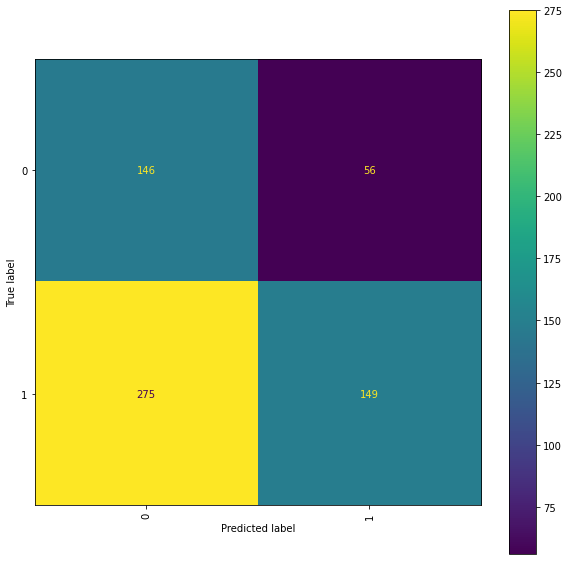

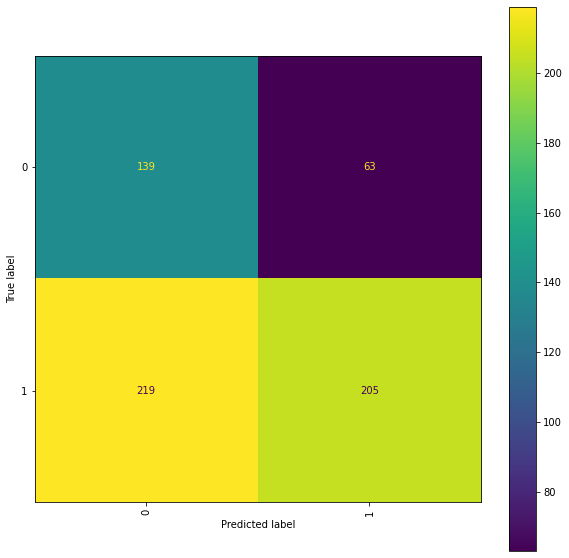

In [ ]:
threshold_values = [0,0.05]

for threshold in threshold_values:
  evaluate_classifier(classify_image,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.1 ------------------------
Accuracy: 0.65814696485623
Precision: 0.6301731418918919
Recall: 0.6439613300952737
F1-Score: 0.6316148405618558


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.15 ------------------------
Accuracy: 0.7204472843450479
Precision: 0.6757244123865191
Recall: 0.648479824397534
F1-Score: 0.6559737466044875


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.2 ------------------------
Accuracy: 0.7220447284345048
Precision: 0.7100381066987564
Recall: 0.5978189800112086
F1-Score: 0.5935246966100935


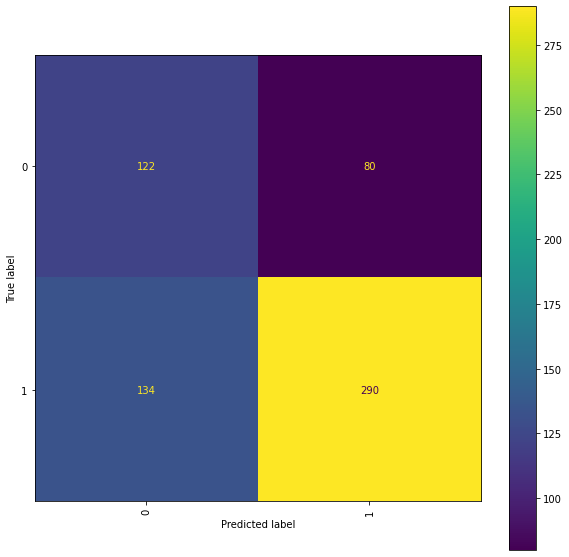

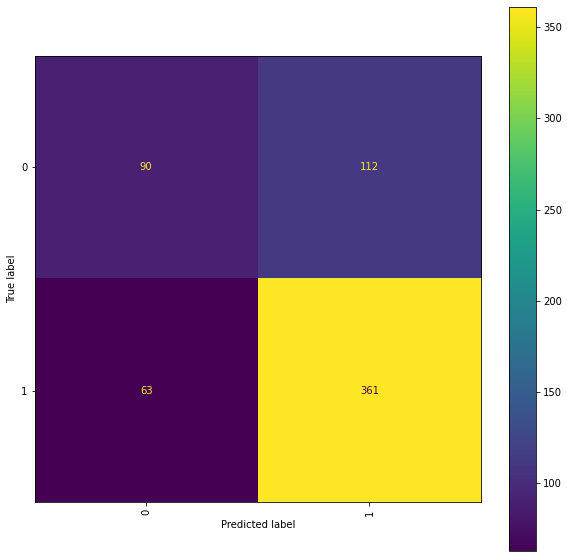

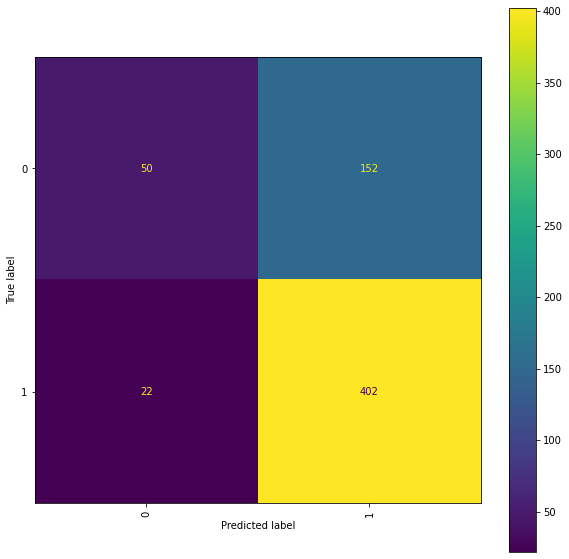

In [ ]:
threshold_values = [0.1,0.15,0.2]

for threshold in threshold_values:
  evaluate_classifier(classify_image,threshold)

In [ ]:
threshold_values = [0.16,0.17,0.18]

for threshold in threshold_values:
  evaluate_classifier(classify_image,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.16 ------------------------
Accuracy: 0.7236421725239617
Precision: 0.681793225457152
Recall: 0.6391742947879694
F1-Score: 0.6474617099887694


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.17 ------------------------
Accuracy: 0.7236421725239617
Precision: 0.68647898014456
Recall: 0.6262142723706332
F1-Score: 0.6330809235825244


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.18 ------------------------
Accuracy: 0.7220447284345048
Precision: 0.6888212927756654
Recall: 0.6159630113954792
F1-Score: 0.6203415824329035


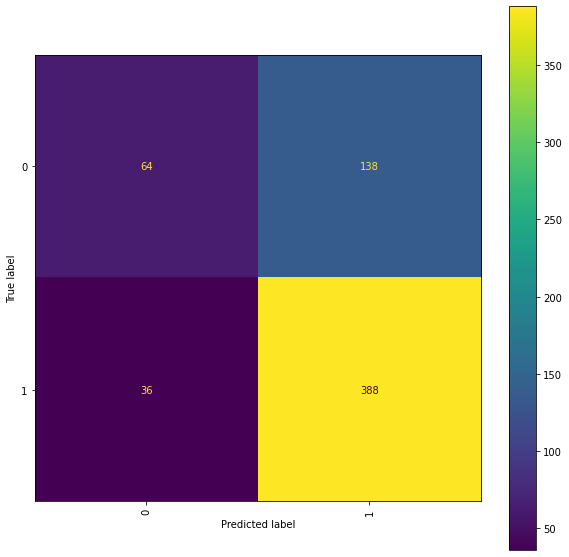

In [ ]:
threshold_values = [0.18]

for threshold in threshold_values:
  evaluate_classifier(classify_image,threshold)

# Inscribed circles

Let us visualize the previous image bounding boxes considering inscribed circles

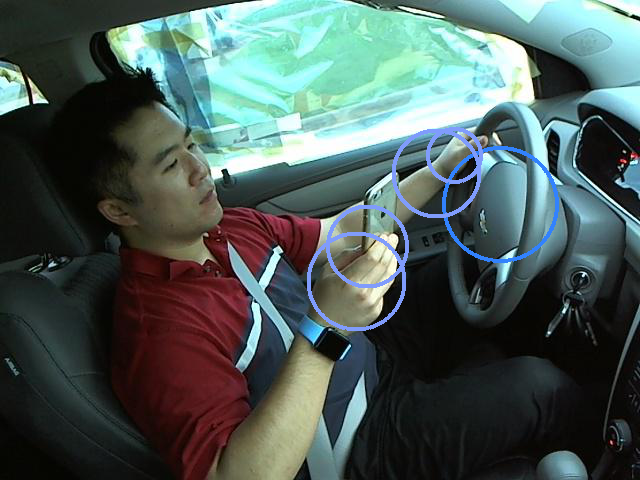

In [ ]:
draw_boxes(filename, boxes, labels)

Function to perform the classification of a test image using circles inscribed into the bounding boxes

In [ ]:
def classify_image_inscribed_circles(filename,threshold):

  """ Consider a test image and classify it.
  Args:
    - filename (str): path to the image to load
    - threshold (float): distance threshold to use for the classification 
  Returns:
    - class (int): the test image class
  """

  image_pil = Image.open(filename)
  image_np = np.array(image_pil)               # convert PIL image to numpy
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_np = image_np.astype(np.float32)       # convert from uint8 to float32
  image_np = image_np / 255.                   # scale from [0, 255] -> [0, 1]
  image_tf = tf.convert_to_tensor(image_np)    # from numpy to tf.Tensor

  detector_output = detector(image_tf)

  labels = []

  # Get the wheel bounding box with the highest score
  wheel_scores = [score for l,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel")]
  # If the wheel is not detected, the image can be discarded
  if len(wheel_scores) == 0:
    return -1
  max_wheel_score = max(wheel_scores)
  best_wheel_box = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel" and score == max_wheel_score)]

  labels.append("Wheel")
  boxes = best_wheel_box

  # Get the "best" (with a minimum score) hands bounding boxes
  min_hand_score = 0.01
  best_hand_boxes = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Human hand" and score >= min_hand_score)]
  for i in range(len(best_hand_boxes)):
    labels.append("Human hand")

  # If the detector is not able to find human hands it is likely that the hands of the driver are not well-visible on the wheel, threfore we label the driver
  # as not focused (class 1)
  if len(best_hand_boxes) == 0:
    return 1

  boxes = np.concatenate((boxes,best_hand_boxes))

  # boxes[0] -> wheel box
  # boxes[1:] -> hand boxes

  # Get the center and the radius of the wheel circle (without rescaling)
  wheel_radius, wheel_center_x, wheel_center_y = get_inscribed_circle(boxes[0][0],boxes[0][2],boxes[0][2],boxes[0][3])

  for i,(y0, x0, y1, x1) in zip(range(len(boxes[1:])),boxes[1:]):
    r,xc,yc = get_inscribed_circle(y0, x0, y1, x1)
    distance = math.sqrt( pow(xc-wheel_center_x,2)+ pow(yc-wheel_center_y,2) )
    if r + wheel_radius < distance + threshold:
      return 1

  return 0 # both the hands on the wheel

We test different values of the distance threshold

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0 ------------------------
Accuracy: 0.7284345047923323
Precision: 0.6996145786558898
Recall: 0.6245679992527555
F1-Score: 0.6307322895847214


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.02 ------------------------
Accuracy: 0.7156549520766773
Precision: 0.694344163658243
Recall: 0.590509994395666
F1-Score: 0.5841804367620498


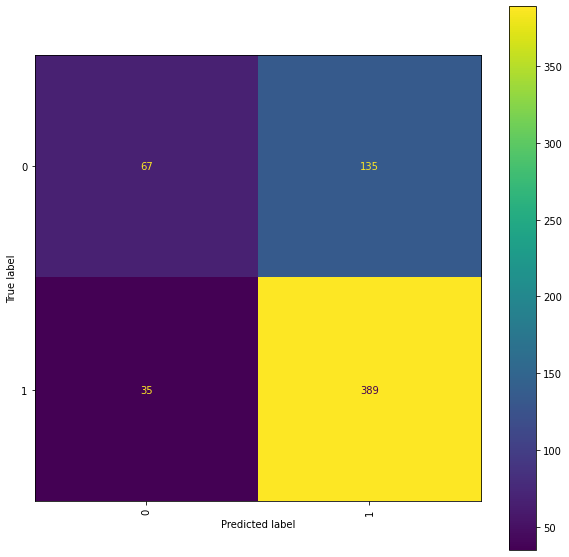

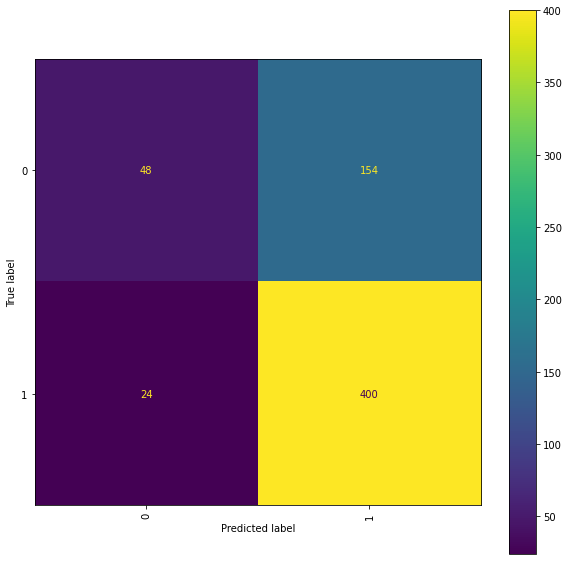

In [ ]:
threshold_values = [0,0.02]
for threshold in threshold_values:
  evaluate_classifier(classify_image_inscribed_circles,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = -0.05 ------------------------
Accuracy: 0.7348242811501597
Precision: 0.6949263502454992
Recall: 0.6668690453951056
F1-Score: 0.6753152612700436


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = -0.02 ------------------------
Accuracy: 0.7396166134185304
Precision: 0.7124734110439888
Recall: 0.6457827386512236
F1-Score: 0.6557364328008233


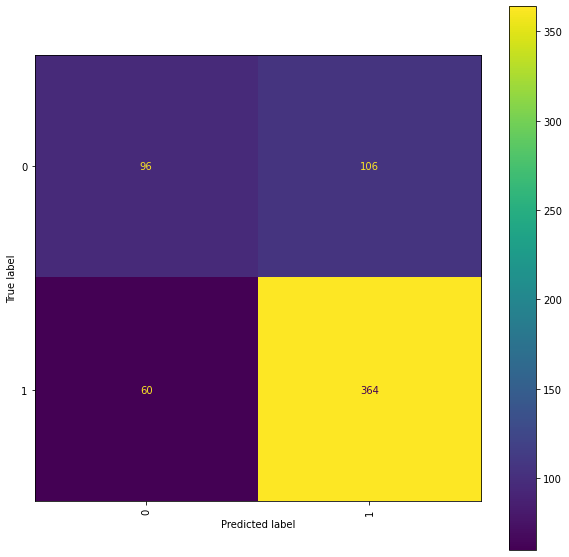

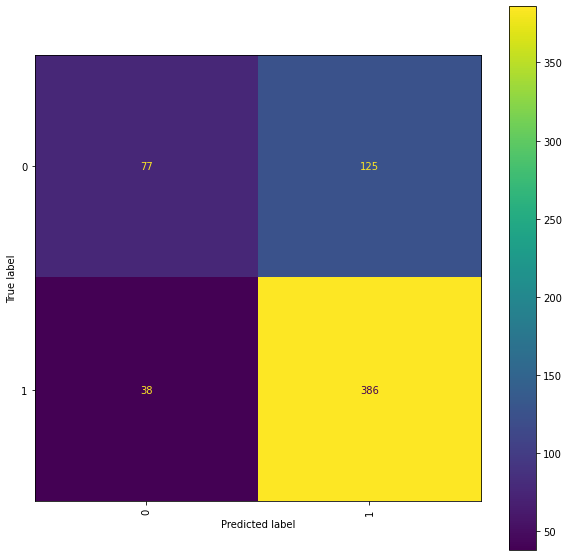

In [ ]:
threshold_values = [-0.05,-0.02]
for threshold in threshold_values:
  evaluate_classifier(classify_image_inscribed_circles,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = -0.07 ------------------------
Accuracy: 0.7156549520766773
Precision: 0.6726339932399807
Recall: 0.6669741266579488
F1-Score: 0.6694708115804462


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = -0.1 ------------------------
Accuracy: 0.6533546325878594
Precision: 0.6283034283379946
Recall: 0.6430155987296843
F1-Score: 0.6288013553578993


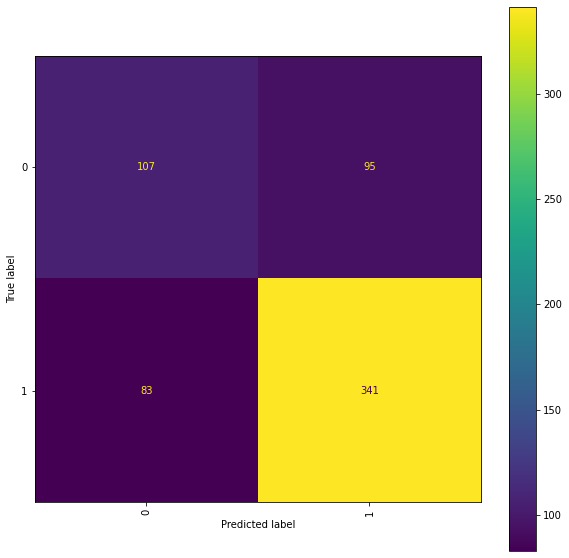

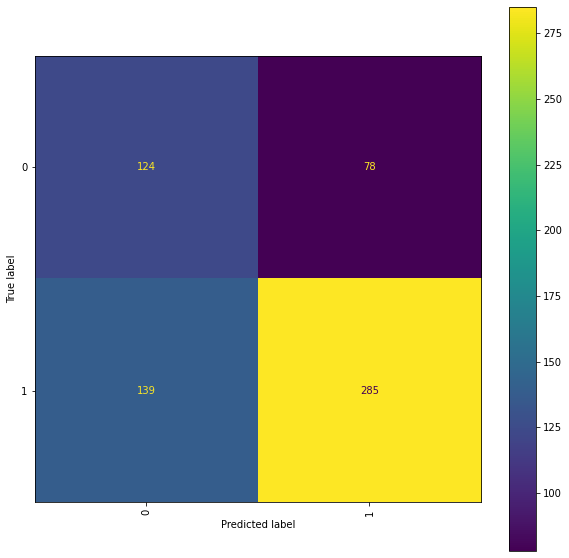

In [ ]:
threshold_values = [-0.07,-0.1]
for threshold in threshold_values:
  evaluate_classifier(classify_image_inscribed_circles,threshold)

# Using distance between centers

If one hand center has a distance from the wheel center greater than a given threshold, it means that the hand is far from the wheel. Therefore the driver has not both the hands on the wheel (class 1)

In [ ]:
def classify_image_distance(filename,threshold):

  """ Consider a test image and classify it.
  Args:
    - filename (str): path to the image to load
    - threshold (float): distance threshold to use for the classification 
  Returns:
    - class (int): the test image class
  """

  image_pil = Image.open(filename)
  image_np = np.array(image_pil)               # convert PIL image to numpy
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_np = image_np.astype(np.float32)       # convert from uint8 to float32
  image_np = image_np / 255.                   # scale from [0, 255] -> [0, 1]
  image_tf = tf.convert_to_tensor(image_np)    # from numpy to tf.Tensor

  detector_output = detector(image_tf)

  labels = []

  # Get the wheel bounding box with the highest score
  wheel_scores = [score for l,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel")]
  # If the wheel is not detected, the image can be discarded
  if len(wheel_scores) == 0:
    return -1
  max_wheel_score = max(wheel_scores)
  best_wheel_box = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Wheel" and score == max_wheel_score)]

  labels.append("Wheel")
  boxes = best_wheel_box

  # Get the "best" (with a minimum score) hands bounding boxes
  min_hand_score = 0.01
  best_hand_boxes = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Human hand" and score >= min_hand_score)]
  for i in range(len(best_hand_boxes)):
    labels.append("Human hand")

  # If the detector is not able to find human hands it is likely that the hands of the driver are not well-visible on the wheel, threfore we label the driver
  # as not focused (class 1)
  if len(best_hand_boxes) == 0:
    return 1

  boxes = np.concatenate((boxes,best_hand_boxes))

  # boxes[0] -> wheel box
  # boxes[1:] -> hand boxes

  # Get the center and the radius of the wheel circle (without rescaling)
  wheel_radius, wheel_center_x, wheel_center_y = get_inscribed_circle(boxes[0][0],boxes[0][2],boxes[0][2],boxes[0][3])
  #print(wheel_radius, wheel_center_x,wheel_center_y)

  for i,(y0, x0, y1, x1) in zip(range(len(boxes[1:])),boxes[1:]):
    r,xc,yc = get_inscribed_circle(y0, x0, y1, x1)
    distance = math.sqrt( pow(xc-wheel_center_x,2)+ pow(yc-wheel_center_y,2) )
    if distance > threshold:
      return 1

  return 0 # both the hands on the wheel

We test different values of the distance threshold

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.1 ------------------------
Accuracy: 0.6996805111821086
Precision: 0.7723597359735974
Recall: 0.5385414720717355
F1-Score: 0.4853144406542465


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.15 ------------------------
Accuracy: 0.7188498402555911
Precision: 0.7542564823492659
Recall: 0.5760204558191668
F1-Score: 0.5548012736588599


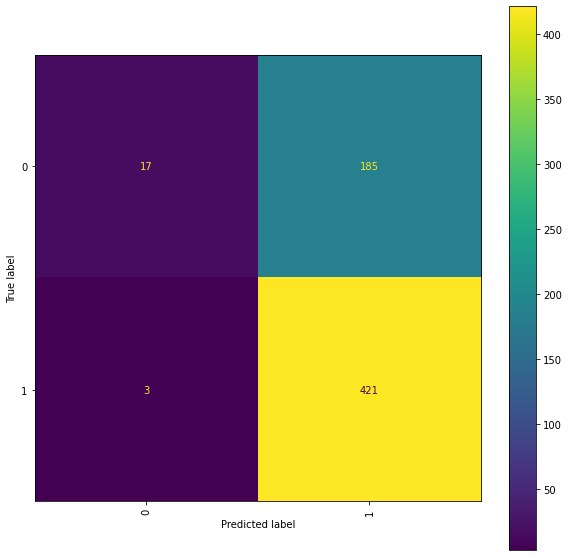

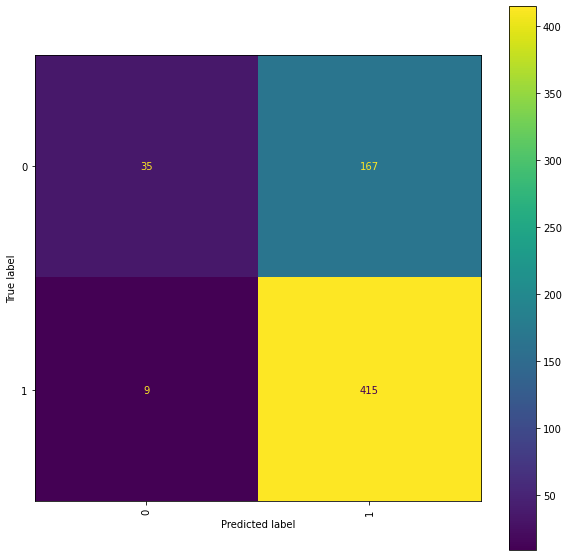

In [ ]:
threshold_values = [0.1,0.15]
for threshold in threshold_values:
  evaluate_classifier(classify_image_distance,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.2 ------------------------
Accuracy: 0.7587859424920128
Precision: 0.7524266520427749
Recall: 0.6612296842891836
F1-Score: 0.6741774813436052


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.25 ------------------------
Accuracy: 0.7396166134185304
Precision: 0.7006618863761721
Recall: 0.6911428171118998
F1-Score: 0.6951860315753312


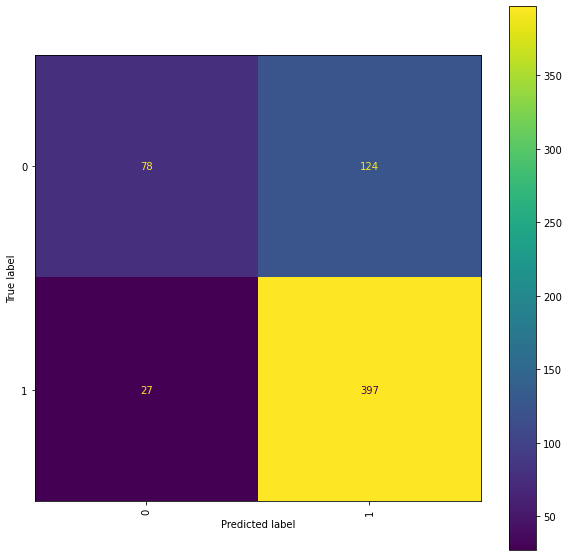

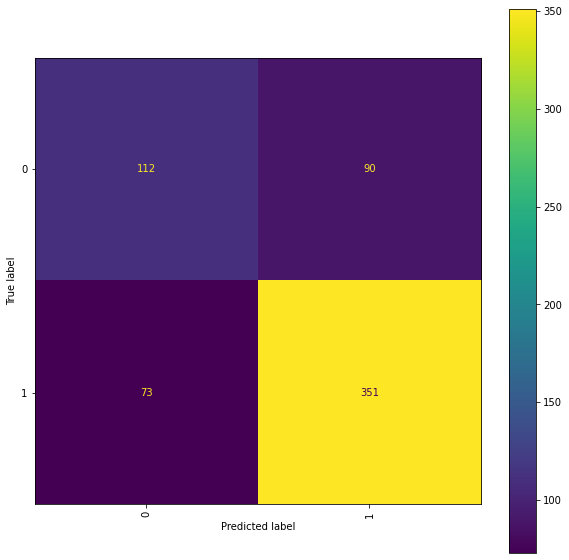

In [ ]:
threshold_values = [0.2,0.25]
for threshold in threshold_values:
  evaluate_classifier(classify_image_distance,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.26 ------------------------
Accuracy: 0.7124600638977636
Precision: 0.6728250915750915
Recall: 0.6762796562675135
F1-Score: 0.6744105409153953


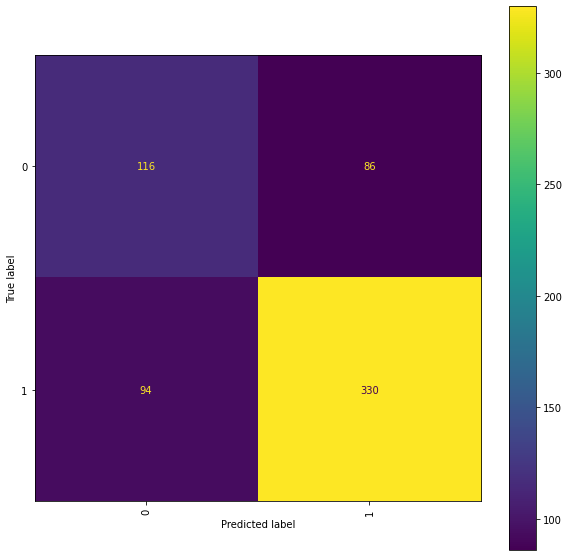

In [ ]:
threshold_values = [0.26]
for threshold in threshold_values:
  evaluate_classifier(classify_image_distance,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.27 ------------------------
Accuracy: 0.6932907348242812
Precision: 0.656061946902655
Recall: 0.6647207173547542
F1-Score: 0.6591960802105072


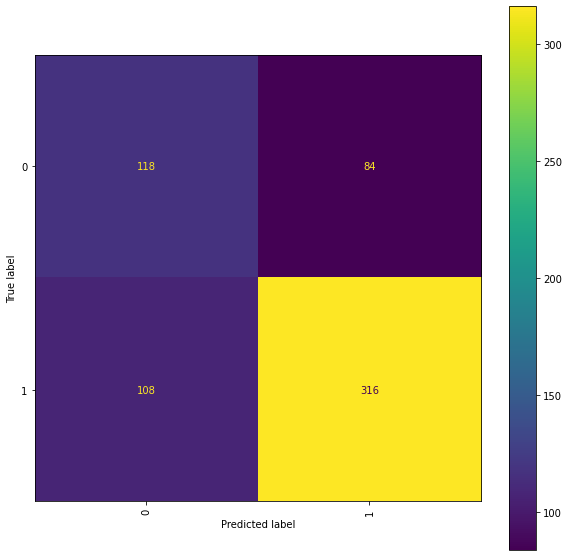

In [ ]:
threshold_values = [0.27]
for threshold in threshold_values:
  evaluate_classifier(classify_image_distance,threshold)

Plot the F1-score values obtained considering different thresholds

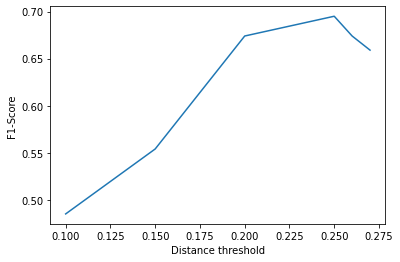

In [ ]:
x=[0.1, 0.15, 0.2, 0.25, 0.26, 0.27]
y=[0.485, 0.554, 0.674, 0.695, 0.674, 0.659]
plt.plot(x, y)
plt.ylabel("F1-Score")
plt.xlabel("Distance threshold")
plt.show()


# Max distance between pairs of hands

We also tried a different approach considering the maximum distance between any pair of hand bounding boxes. If this distance is greater than a certain threshold, the image is classified with class "Driver without both hands on the steering wheel"

In [ ]:
def classify_image_max_hand_distance(filename,threshold):

  """ Consider a test image and classify it.
  Args:
    - filename (str): path to the image to load
    - threshold (float): distance threshold to use for the classification 
  Returns:
    - class (int): the test image class
  """

  image_pil = Image.open(filename)
  image_np = np.array(image_pil)               # convert PIL image to numpy
  image_np = np.expand_dims(image_np, axis=0)  # add batch dimension
  image_np = image_np.astype(np.float32)       # convert from uint8 to float32
  image_np = image_np / 255.                   # scale from [0, 255] -> [0, 1]
  image_tf = tf.convert_to_tensor(image_np)    # from numpy to tf.Tensor

  detector_output = detector(image_tf)

  labels = []

  # Get the "best" (with a minimum score) hands bounding boxes
  min_hand_score = 0.01
  best_hand_boxes = [b for l,b,score in zip(detector_output['detection_class_entities'].numpy().tolist(),detector_output['detection_boxes'].numpy(),detector_output['detection_scores'].numpy().tolist()) if (l.decode('utf8')=="Human hand" and score >= min_hand_score)]
  for i in range(len(best_hand_boxes)):
    labels.append("Human hand")

  # If the detector is not able to find human hands it is likely that the hands of the driver are not well-visible on the wheel, threfore we label the driver
  # as not focused (class 1)
  if len(best_hand_boxes) == 0:
    return 1

  boxes = best_hand_boxes

  r_hands = []
  xc_hands = []
  yc_hands = []

  for i,(y0, x0, y1, x1) in zip(range(len(boxes)),boxes):
    r,xc,yc = get_inscribed_circle(y0, x0, y1, x1)
    r_hands.append(r)
    xc_hands.append(xc)
    yc_hands.append(yc)

  max_distance = 0
  for i in range(len(r_hands)):
    for j in range(len(r_hands)):
      distance = math.sqrt( pow(xc_hands[i]-xc_hands[j],2) + pow(yc_hands[i]-yc_hands[j],2) )
      if distance > max_distance:
        max_distance = distance

  if max_distance > threshold:
    return 1

  return 0 # both the hands on the wheel

We test different values of the distance threshold

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.1 ------------------------
Accuracy: 0.5712050078247262
Precision: 0.4891911093068101
Recall: 0.4906103286384977
F1-Score: 0.4869124369944907


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.2 ------------------------
Accuracy: 0.6369327073552425
Precision: 0.61175461608314
Recall: 0.6220657276995305
F1-Score: 0.6123221757322176


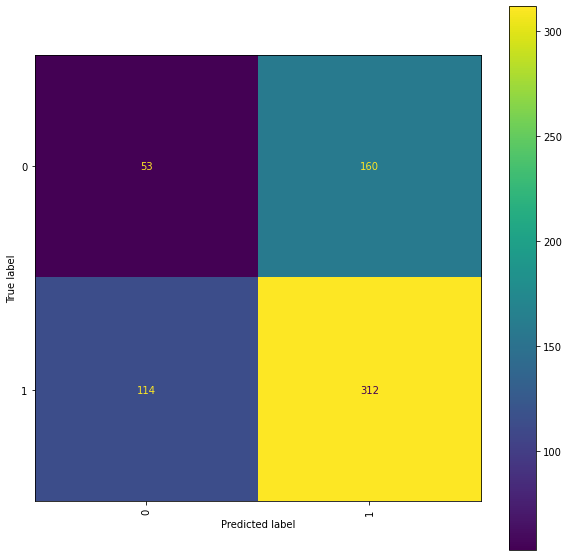

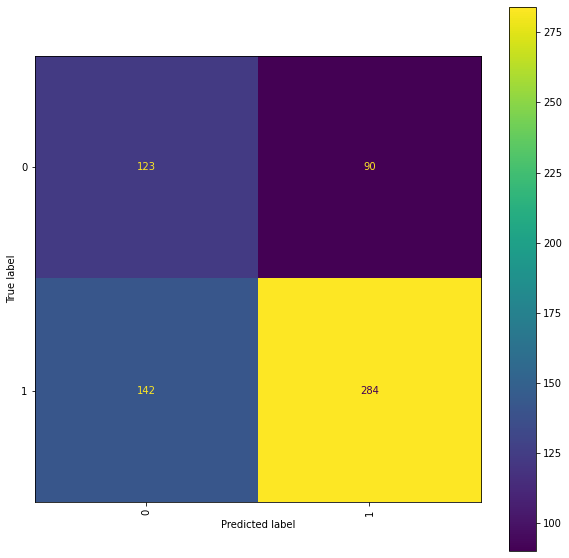

In [ ]:
thresholds = [0.1,0.2]
for threshold in thresholds:
  evaluate_classifier(classify_image_max_hand_distance,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.15 ------------------------
Accuracy: 0.5899843505477308
Precision: 0.5347139485219736
Recall: 0.534037558685446
F1-Score: 0.5342772894180483


  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.25 ------------------------
Accuracy: 0.6134585289514867
Precision: 0.6106222439980402
Recall: 0.6244131455399061
F1-Score: 0.6012072454943063


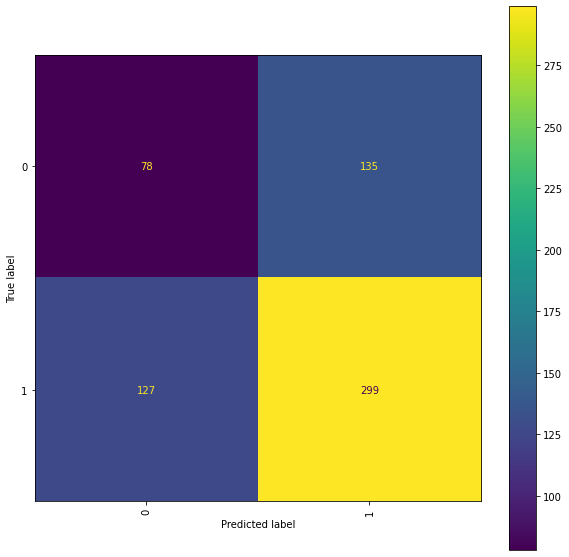

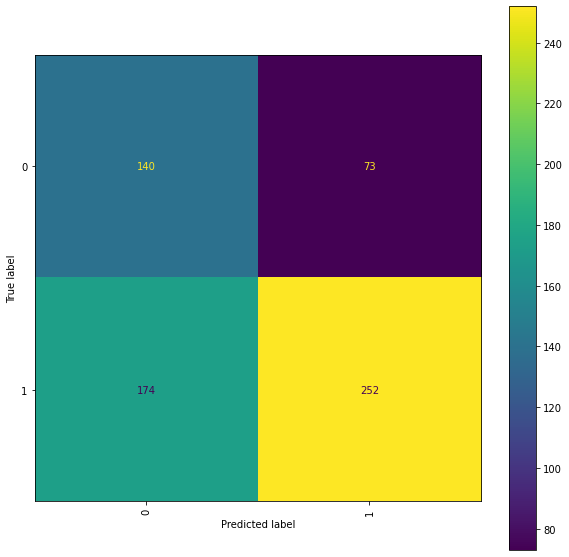

In [ ]:
thresholds = [0.15,0.25]
for threshold in thresholds:
  evaluate_classifier(classify_image_max_hand_distance,threshold)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

------------------------ Threshold = 0.27 ------------------------
Accuracy: 0.6025039123630673
Precision: 0.6097420950362127
Recall: 0.6232394366197183
F1-Score: 0.5939019996397046


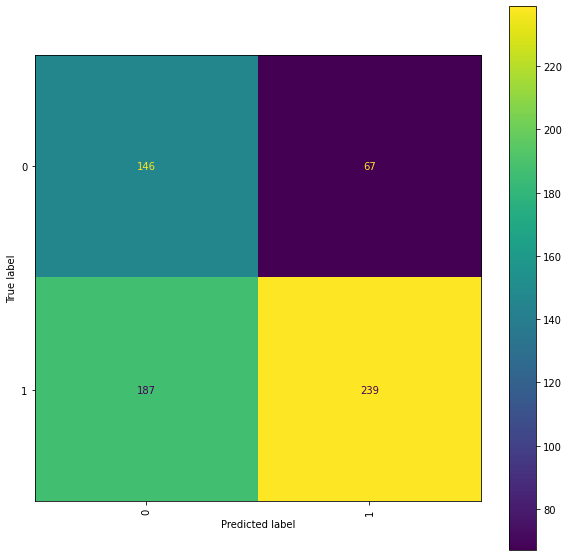

In [ ]:
thresholds = [0.27]
for threshold in thresholds:
  evaluate_classifier(classify_image_max_hand_distance,threshold)

Let us compare the F1-scores obtained by the two different methods ("Using distance between centers" and "Max distance between pairs of hands")

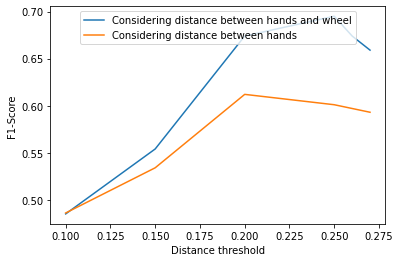

In [ ]:
x=[0.1, 0.15, 0.2, 0.25, 0.26, 0.27]
y=[0.485, 0.554, 0.674, 0.695, 0.674, 0.659]
plt.plot(x, y, label="Considering distance between hands and wheel")
x=[0.1, 0.15, 0.2, 0.25, 0.27]
y=[0.486, 0.534, 0.612, 0.601, 0.593]
plt.plot(x, y, label="Considering distance between hands")


plt.legend(loc="upper center")
plt.ylabel("F1-Score")
plt.xlabel("Distance threshold")
plt.show()
